In [ ]:
# The dataset used in this example is referenced from:

# S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 
# 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 
# 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

# It consists of a synthetic dataset for predictive maintenance of a milling machine, containing 10000 points and 14 features:
# 1 - UID: unique identifier ranging from 1 to 10000
# 2 - product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
# 3 - type: just the product type L, M or H from column 2
# 4 - air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
# 5 - process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
# 6 - rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
# 7 - torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
# 8 - tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
# 9 - machine failure: a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

# And the machine failures consists of five independent failure modes:
# 1 - tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). 
# At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

# 2 - heat dissipation failure (HDF): heat dissipation causes a process failure, 
# if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

# 3 - power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. 
# If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

# 4 - overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. 
# This is true for 98 datapoints.

# 5 - random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. 
# This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

# If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.
# This dataset is part of the following publication, please cite when using this dataset:

In [2]:
import pandas as pd
import numpy as np

# Loading dataset
df = pd.read_csv('ai4i2020.csv')

print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [3]:
# Since we aim to predict when the machine is in failure state, we will focus on the 'machine failure' column as our target variable and remove the failure modes from the dataset

In [ ]:
# --- 1. DATA CLEANING ---

# A) Failure identifiers and ID columns to remove
columns_to_remove = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df.drop(columns=columns_to_remove)

# B) Transforming categorical variables into dummy numerical variables
df_clean = pd.get_dummies(df, columns=['Type'], drop_first=True, dtype=np.int8) # dtype specified to reduce memory usage and enable compatibility for linear algebra operations

# C) Renaming columns for easier access
df_clean.columns = ['Air_temp', 'Process_temp', 'Rot_speed', 'Torque', 'Tool_wear', 'Target', 'Type_L', 'Type_M'] # Type_H becomes our reference category

# Dataframe after cleaning:
print(df_clean.info())
print(df_clean.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Air_temp      10000 non-null  float64
 1   Process_temp  10000 non-null  float64
 2   Rot_speed     10000 non-null  int64  
 3   Torque        10000 non-null  float64
 4   Tool_wear     10000 non-null  int64  
 5   Target        10000 non-null  int64  
 6   Type_L        10000 non-null  int8   
 7   Type_M        10000 non-null  int8   
dtypes: float64(3), int64(3), int8(2)
memory usage: 488.4 KB
None
   Air_temp  Process_temp  Rot_speed  Torque  Tool_wear  Target  Type_L  \
0     298.1         308.6       1551    42.8          0       0       0   
1     298.2         308.7       1408    46.3          3       0       1   
2     298.1         308.5       1498    49.4          5       0       1   
3     298.2         308.6       1433    39.5          7       0       1   
4     298.2         30

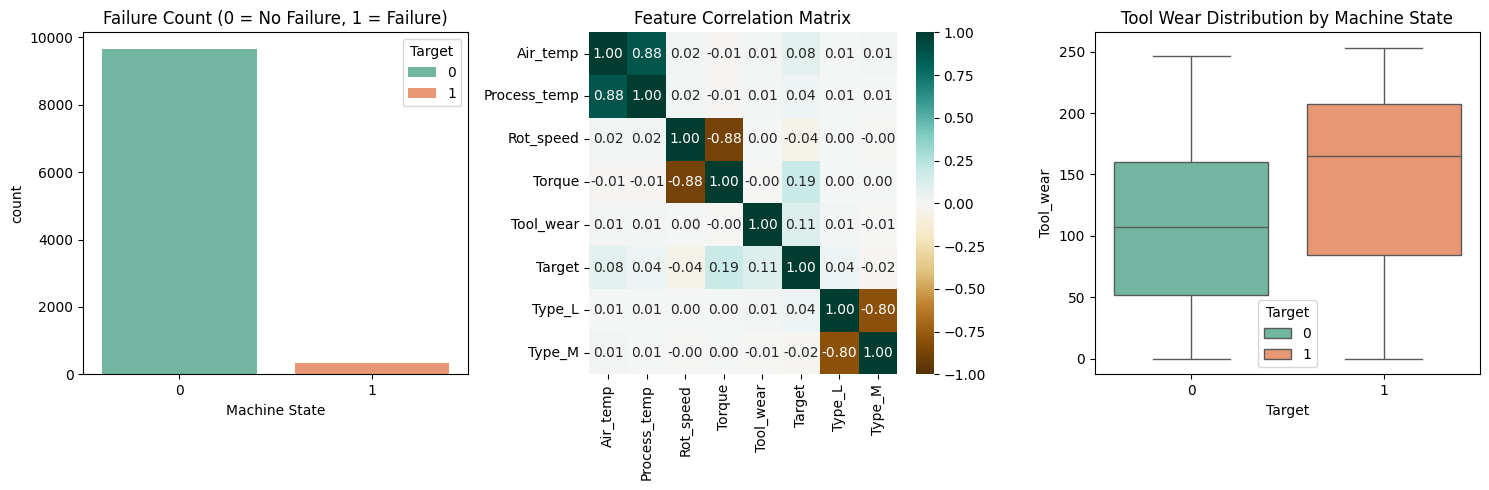

In [5]:
# --- 2. EXPLORATORY DATA ANALYSIS ---
import matplotlib.pyplot as plt
import seaborn as sns

# Figure size configuration
plt.figure(figsize=(15, 5))

# A) Verifying distribution of target variable
plt.subplot(1, 3, 1)
sns.countplot(x='Target', data=df_clean, palette='Set2', hue='Target')
plt.title('Failure Count (0 = No Failure, 1 = Failure)')
plt.xlabel('Machine State')

# B) Verifying correlation for multicolinearity
plt.subplot(1, 3, 2)
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='BrBG', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')

# C) Boxplot for feature distribution by target variable
plt.subplot(1, 3, 3)
sns.boxplot(x='Target', y='Tool_wear', data=df_clean, palette='Set2', hue='Target')
plt.title('Tool Wear Distribution by Machine State')

plt.tight_layout()
plt.show()

In [ ]:
# --- 3. MULITCOLIENARITY CHECK (Variance Inflation Factor) ---
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculation of VIF for each numerical feature
X_vif = df_clean[['Air_temp', 'Process_temp', 'Rot_speed', 'Torque', 'Tool_wear', 'Type_L', 'Type_M']]
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_data)



--- Variance Inflation Factor (VIF) ---
        feature           VIF
0      Air_temp  87435.495498
1  Process_temp  88289.513849
2     Rot_speed    315.388594
3        Torque     72.139059
4     Tool_wear      3.877508
5        Type_L      6.986861
6        Type_M      3.990386


In [7]:
# Since Air_temp, Process_temp, Rot_speed and Torque have high VIF values (> 10), we will remove them from the dataset to reduce multicolinearity by selecting Process_temp as the only
# temperature related feature, and transforming Rot_speed and Torque into a new feature 'Power' calculated as (2 * pi * Rot_speed/60) * Torque that can carry information from both features 
# without multicolinearity issues

In [8]:
# --- 4. MODEL ADJUSTMENT ---
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# A) Final data preparation
X = df_clean.drop(columns=['Air_temp', 'Target'])
y = df_clean['Target']

# B) Adding intercept term for scale correction
X = sm.add_constant(X)

# C) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify to maintain class distribution due to low proportion of failures

# D) Logistic Regression Model Fitting
model = sm.Logit(y_train, X_train).fit()

# E) Model Summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.099757
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6993
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Dec 2025   Pseudo R-squ.:                  0.3255
Time:                        19:07:26   Log-Likelihood:                -698.30
converged:                       True   LL-Null:                       -1035.3
Covariance Type:            nonrobust   LLR p-value:                2.425e-142
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -94.9195     15.977     -5.941      0.000    -126.233     -63.606
Process_temp     0.1918

In [9]:
# From the model summary we can conclude the following:
# 1 - We have no statistical evidence to reject the null hypothesis that the Type_M machines failures differently than the Type_H machines (p-value > 0.05). 
# Therefore, we can remove this variable from the model in the future to simplify it.
# 2 - Type_L machines failures are significantly higher than Type_H machines (p-value < 0.05), indicating that product type has an impact on failure rates.
# 3 - All other features have p-values < 0.05, indicating they are statistically significant predictors of machine failure, which shows that the model has accurately captured the 
# underlying physical relationships leading to machine failures.

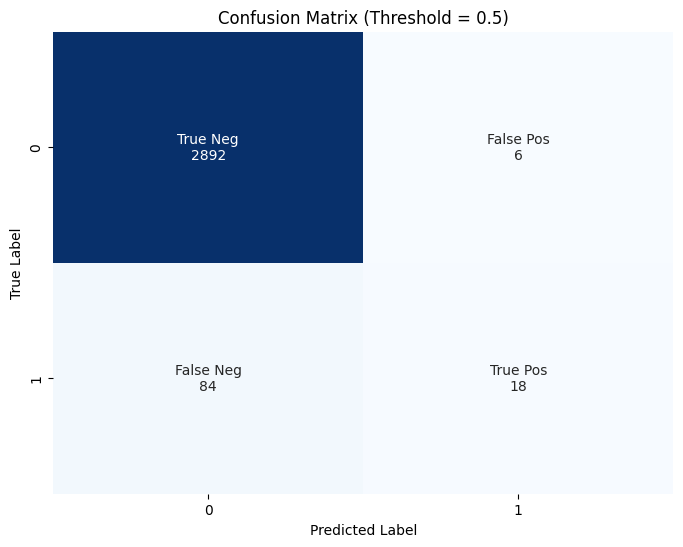

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2898
           1       0.75      0.18      0.29       102

    accuracy                           0.97      3000
   macro avg       0.86      0.59      0.64      3000
weighted avg       0.96      0.97      0.96      3000

AUC-ROC: 0.8408


In [10]:
# --- 5. MODEL EVALUATION ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# A) Predictions on test set
y_prob = model.predict(X_test)

# B) Thresholding probabilities to obtain class predictions
threshold = 0.5 # conservative
y_pred = (y_prob > threshold).astype(int)

# C) Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# D) Print classification report
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

In [11]:
# In predictive maintenance, accuracy is NOT the most important metric, sensibility (recall) is prioritized to minimize false negatives (missed failures) which can lead to costly downtimes.

# Recall is calculated as TP / (TP + FN), thus focusing on capturing as many actual failures as possible.

# Thus, we aim to maximize recall even at the cost of some false positives, which can be managed with further inspections.

# Therefore with a class 1 recall of 18.6%, we are able to identify 18.6% of all actual failures in the test set, which deem this model as useless for predictive maintenance purposes because
# the cost of missing 81.4% of failures is much higher than sending an inspection team to check a false positive machine

# To increase the recall we must lower the threshold so the model classifies more instances as failures (class 1), thus reducing false negatives at the cost of increasing false positives - which is
# much more acceptable in predictive maintenance scenarios. In other words, it is better to send an inspection team to check a good machine than to miss a real failure.

# That said, we're going to optimize the threshold by maximizing the F1-score, which is an harmonic mean of precision and recall

--- Optimal Threshold (threshold tuning) ---
Best Threshold: 0.2670
Best F1-Score: 0.4581

--- Confusion Matrix with Optimized Threshold ---


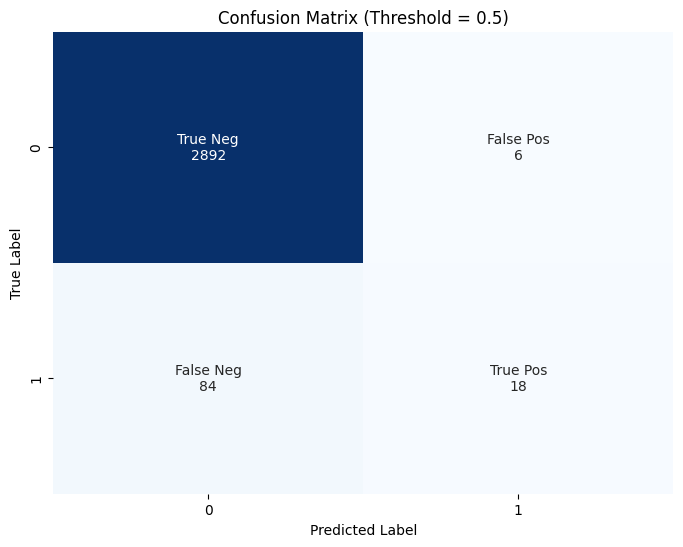


--- Classification Report with Optimized Threshold ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2898
           1       0.53      0.39      0.45       102

    accuracy                           0.97      3000
   macro avg       0.75      0.69      0.72      3000
weighted avg       0.96      0.97      0.97      3000

AUC-ROC: 0.8408


In [12]:
# --- 6. POST-PROCESSING ---
from sklearn.metrics import precision_recall_curve, f1_score

# A) Precision-Recall Curve to find optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# B) F1-score calculation for each threshold
numerator = 2*recalls*precisions
denominator = recalls + precisions
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

# C) Finding higher F1-score and corresponding threshold
max_f1 = np.argmax(f1_scores)
best_threshold = thresholds[max_f1]
best_f1 = f1_scores[max_f1]

print(f'--- Optimal Threshold (threshold tuning) ---')
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1-Score: {best_f1:.4f}')

# D) Re-evaluating model with optimal threshold
y_pred_optimized = (y_prob > best_threshold).astype(int)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

print("\n--- Confusion Matrix with Optimized Threshold ---")
plt.figure(figsize=(8, 6))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Classification Report with Optimized Threshold ---")
print(classification_report(y_test, y_pred_optimized))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

In [13]:
# Even with threshold optimization, the recall for class 1 remains low at 39%, indicating that the model struggles to effectively identify failures in this dataset.

# This could be due to the logistic GLM is a linear classifier and is suffering with the severe unbalance of the failure proportion in the dataset. In other words, it has not seen many failures
# to be able to properly identify them

# To improve recall further, a more advanced technique such as SMOTE (Synthetic Minority Oversampling Technique) for balancing classes must be applied, this algorithm creates synthetic samples 
# of the minority class (failures) through KNN method to balance the dataset and help the model learn better decision boundaries

Before SMOTE: {0: 6763, 1: 237}
After SMOTE: {0: 6763, 1: 6763}
Optimization terminated successfully.
         Current function value: 0.369190
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                13526
Model:                          Logit   Df Residuals:                    13519
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Dec 2025   Pseudo R-squ.:                  0.4674
Time:                        19:07:28   Log-Likelihood:                -4993.7
converged:                       True   LL-Null:                       -9375.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -110.5273      6.171    -1

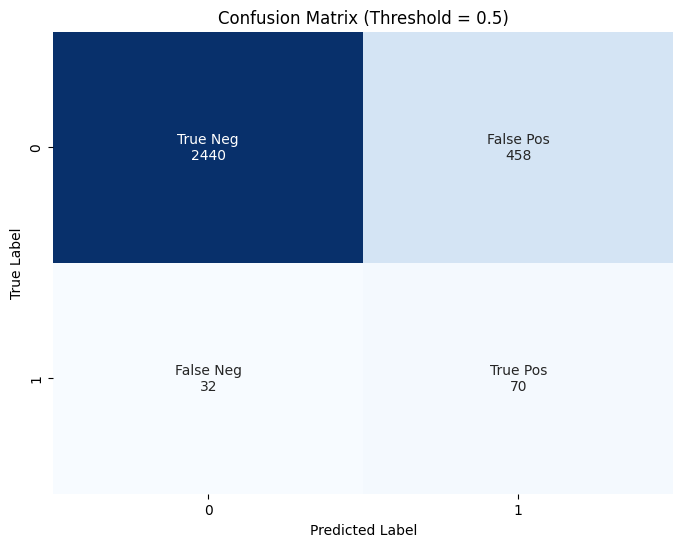


--- Classification Report with SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2898
           1       0.13      0.69      0.22       102

    accuracy                           0.84      3000
   macro avg       0.56      0.76      0.57      3000
weighted avg       0.96      0.84      0.89      3000

AUC-ROC: 0.8408


In [14]:
# --- 7. SMOTE IMPLEMENTATION ---
from imblearn.over_sampling import SMOTE

# A) Applying SMOTE to training data
smote = SMOTE(random_state=42, sampling_strategy=1) # sampling_strategy=1 means we are balancing classes equally
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Before SMOTE: {y_train.value_counts().to_dict()}')
print(f'After SMOTE: {y_train_smote.value_counts().to_dict()}')

# B) Re-training model with SMOTE data
model_smote = sm.Logit(y_train_smote, X_train_smote).fit()
print(model_smote.summary())

# C) Predictions on test set
y_prob_smote = model_smote.predict(X_test)

# D) Thresholding probabilities to obtain class predictions
y_pred_smote = (y_prob_smote > 0.5).astype(int)

# E) Results
cm = confusion_matrix(y_test, y_pred_smote)
print("\n--- Confusion Matrix with SMOTE ---")
plt.figure(figsize=(8, 6))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Classification Report with SMOTE ---")
print(classification_report(y_test, y_pred_smote))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

In [ ]:
# By applying SMOTE, we have significantly improved the recall for class 1 to 69%, meaning we are now able to identify 69% of all actual failures in the test set.

# But it is not enough if we are talking about a critical system where failures must be avoided at all costs.

# Now we are going to optimize the threshold again to further improve recall and create the Power variable from Torque and Rot_speed, as well as to add a the temperature gradient 
# between Air_temp and Process_temp to capture more complex relationships in the data that a linear model might miss.

Optimization terminated successfully.
         Current function value: 0.323513
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                13526
Model:                          Logit   Df Residuals:                    13518
Method:                           MLE   Df Model:                            7
Date:                Fri, 26 Dec 2025   Pseudo R-squ.:                  0.5333
Time:                        19:07:28   Log-Likelihood:                -4375.8
converged:                       True   LL-Null:                       -9375.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0448      0.044    -46.597      0.000      -2.131      -1.959
Process_temp    -0.0295

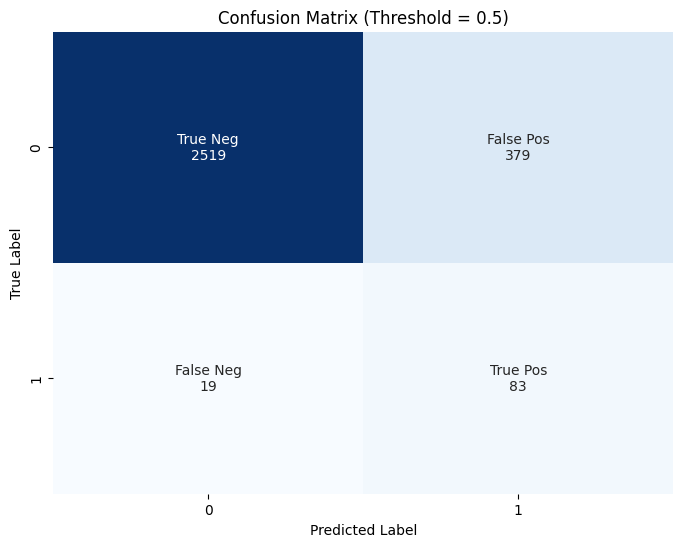


--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2898
           1       0.18      0.81      0.29       102

    accuracy                           0.87      3000
   macro avg       0.59      0.84      0.61      3000
weighted avg       0.96      0.87      0.91      3000

AUC-ROC: 0.9171


In [16]:
# --- 8. FINAL MODEL ADJUSTMENT ---
from sklearn.metrics import fbeta_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

# A) Adding engineered features
df_eng = df_clean.copy()
df_eng['Power'] = (2 * np.pi * df_eng['Rot_speed'] / 60) * df_eng['Torque']*0.001  # Power in kW
df_eng['Temp_diff'] = df_eng['Air_temp'] - df_eng['Process_temp']  # Interaction term between temperatures

# B) Scaling data due to new features with different units and dimensions
X = df_eng.drop(columns=['Air_temp', 'Target', 'Type_M']) # Removing Type_M due to insignificance from previous model
y = df_eng['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# C) Adding intercept term
X_final = sm.add_constant(X_scaled)

# D) Train-test split and SMOTE application
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42, sampling_strategy=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# E) Model fitting
eng_model = sm.Logit(y_train_res, X_train_res).fit()
print(eng_model.summary())

# # F) Threshold optimization
y_prob_final = eng_model.predict(X_test)
thresholds = np.linspace(0.0, 1.0, 100)
f2_scores = []
recalls = []

for t in thresholds:
    y_temp = (y_prob_final > t).astype(int)

    score = fbeta_score(y_test, y_temp, beta=2)
    f2_scores.append(score)
    recalls.append(recall_score(y_test, y_temp))

ix = np.argmax(f2_scores)
best_threshold_final = thresholds[ix]
best_recall_final = recalls[ix]

print(f'--- Statistical and Physical Optimization Results ---')
print(f'Best Threshold: {best_threshold_final:.4f}')
print(f'Expected Recall: {best_recall_final:.4f}')

# G) Final evaluation
y_pred_final = (y_prob_final > 0.5).astype(int) # 0.5 due to SMOTE equally balancing of classes
cm_final = confusion_matrix(y_test, y_pred_final)

print("\n--- Final Confusion Matrix ---")
plt.figure(figsize=(8, 6))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_final.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

sns.heatmap(cm_final, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred_final))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_final):.4f}")

In [17]:
# --- 9. CONCLUSION ---

# By incorporating engineered features, applying SMOTE, and optimizing the classification threshold, we have significantly improved the model's ability to identify machine failures
# and avoid false negatives and costly downtimes with a recall rate of 81%, meaning that 4 out of 5 actual failures are now correctly identified by the model. This demonstrates the effectiveness
# of these techniques in enhancing predictive maintenance models.

# Also the final model summary shows that all features are statistically significant predictors of machine failure, indicating that the model has effectively captured the underlying physical relationships.

# Specifically the engineered features 'Power' and 'Temp_diff' contributed to improving the model's performance by capturing complex interactions in the data, showing that our initial hypothesis
# that the temperature gradient has influence on machine failures was correct

# The model summary shows that Torque is the main contributor to machine failures, followed by Power and Temp_diff, indicating that mechanical stress and thermal conditions are critical factors in predicting 
# machine failures.

# Finally, the negative coeficient for Power is a mathematical correction factor that when Torque and Rot_speed increase together, the failure probability is slightly smaller than the linear sum of their
# individual effects would suggest, indicating a non-linear interaction between these features in relation to machine failures.

# AUC-ROC of 0.9171 indicates that the model has a high capability of distinguishing between failure and non-failure states, further validating its effectiveness for predictive maintenance applications.

# Class 1 recall of 81% demonstrates that 81 out of 100 machine failures are correctly identified, significantly reducing the risk of unexpected downtimes.

# Class 1 precision of 18% reveals the trade-off between identifying failures and the occurrence of false alarms, which is acceptable in predictive maintenance scenarios where missing a failure is more costly
# than investigating a false alarm - thus this prediction model is economically viable for real-world applications.